**Import Libraries**

In [37]:
import os
from glob import glob

# Data Manipulation Libraries
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt

**Define Parameters**

In [38]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/vinbigdata-chest-xray-abnormalities-detection.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/vinbigdata-chest-xray-abnormalities-detection-extracted'

# Disease labels
disease_labels = [
    "Aortic enlargement", "Atelectasis", "Calcification", "Cardiomegaly",
    "Consolidation", "ILD", "Infiltration", "Lung Opacity",
    "Nodule/Mass", "Other lesion", "Pleural effusion", "Pleural thickening",
    "Pneumothorax", "Pulmonary fibrosis"
]

# **Step 1: Load Data**

In [39]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract VinDr-CXR dataset
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [40]:
def load_labels(csv_path, extracted_path):
    """
    Read labels from CSV, maps images to paths, and create binary disease labels.
    """

    # Read the CSV containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['class_name'].str.contains(disease).astype(int)

    # Create binary column for 'No Finding'
    labels_df['No finding'] = labels_df['class_name'].str.contains('No finding').astype(int)

    # Map images to their full path
    labels_df['Path'] = labels_df['image_id'].map(lambda x: os.path.join(extracted_path, 'train', f"{x}.dicom"))

    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'train.csv')

# Load and preprocess the labels
df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Print Dataframe**

In [41]:
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,Aortic enlargement,Atelectasis,...,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No finding,Path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,1,/cluster/home/bjorneme/projects/Data/vinbigdat...
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,1,/cluster/home/bjorneme/projects/Data/vinbigdat...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,0,0,...,0,0,0,0,0,0,0,0,0,/cluster/home/bjorneme/projects/Data/vinbigdat...
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,1,0,...,0,0,0,0,0,0,0,0,0,/cluster/home/bjorneme/projects/Data/vinbigdat...
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,1,/cluster/home/bjorneme/projects/Data/vinbigdat...


# **Step 3: Exploratory Data Analysis (EDA)**

**Number of Unique Images**

In [42]:
unique_patients = df['image_id'].nunique()
print(f"Number of images: {unique_patients}")

Number of images: 15000


**Distribution of Disease Label**

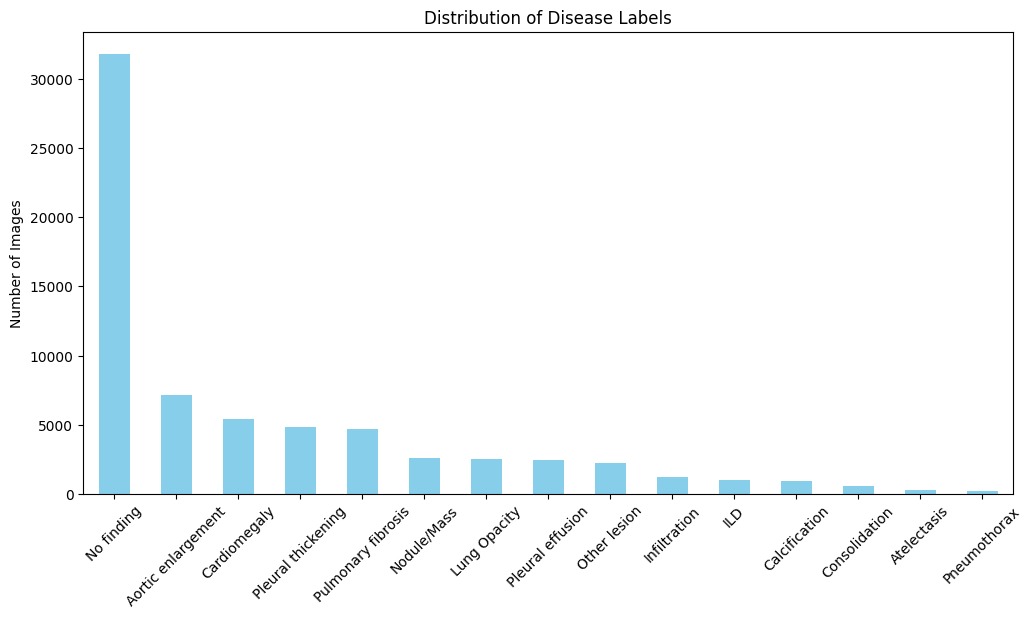

In [43]:
# Retrive labels from dataframe
labels_df = df[disease_labels + ['No finding']]

# Count each label
counted_labels_df = labels_df.sum()

# Sort labels
counted_labels_df = counted_labels_df.sort_values(ascending=False)

# Plott counted_labels
plt.figure(figsize=(12, 6))
counted_labels_df.plot(kind='bar', color='skyblue')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.title('Distribution of Disease Labels')
plt.show()